# Decision Tree	 - Top model according to the SCPM of -2.65	(Dominance count of 190)

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Modeling
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "204",
    "Plant": "F",
    "Features": "Chemical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/204/f.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [8]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [9]:
PARAMS = {
    "criterion": "squared_error",
    "max_depth": 3,
    "random_state": SEED,
    "splitter": "best",
}

<IPython.core.display.Javascript object>

## 1.3. Blocking Time Series Split Cross Validation

In [10]:
n_splits = 5
train_size = 0.8
repeats = 1
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 1
n_splits: 5

******
[TRAIN]
******
RMSE: -1.165 (0.105)
MAE: -0.920 (0.093)
MAPE: -0.021 (0.002)
R2: 0.972 (0.005)


******
[TEST]
******
RMSE: -1.584 (0.677)
MAE: -1.205 (0.395)
MAPE: -0.028 (0.009)
R2: 0.936 (0.055)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [12]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2020-01-02,36.3,35.366667,TRAIN,1
1,2020-01-04,52.2,49.304797,TRAIN,1
2,2020-01-04,48.7,49.304797,TRAIN,1
3,2020-01-05,33.0,34.662295,TRAIN,1
4,2020-01-05,33.8,35.366667,TRAIN,1
...,...,...,...,...,...
2505,2023-06-28,48.1,49.633083,TEST,5
2506,2023-06-28,50.1,49.633083,TEST,5
2507,2023-06-28,48.5,48.376378,TEST,5
2508,2023-06-28,36.5,35.495960,TEST,5


<IPython.core.display.Javascript object>

In [13]:
(df_pred["SET"] == "TEST").sum()

505

<IPython.core.display.Javascript object>

In [14]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [15]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [16]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_decision_tree_tsscv_203_s.xlsx", index=False)
# df_copy_merge.to_csv("local_model_decision_tree_tsscv_203_s.csv", index=False)

<IPython.core.display.Javascript object>

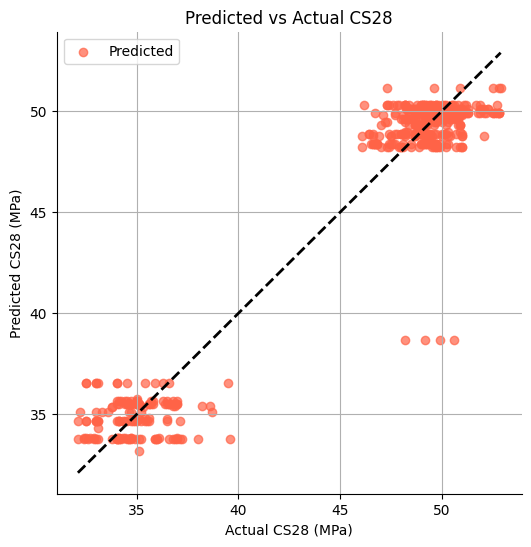

<IPython.core.display.Javascript object>

In [17]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_204_f_local_cm_p_btiss_top_scpm_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

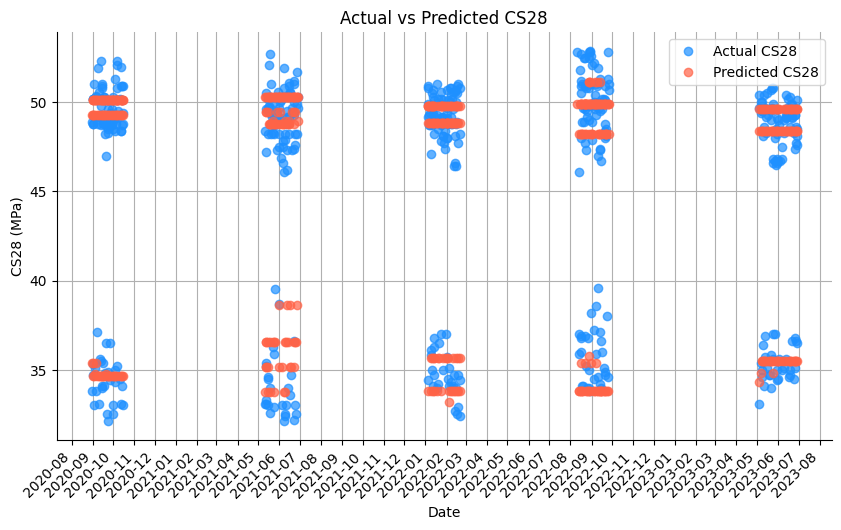

<IPython.core.display.Javascript object>

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_204_f_local_cm_p_btiss_top_scpm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


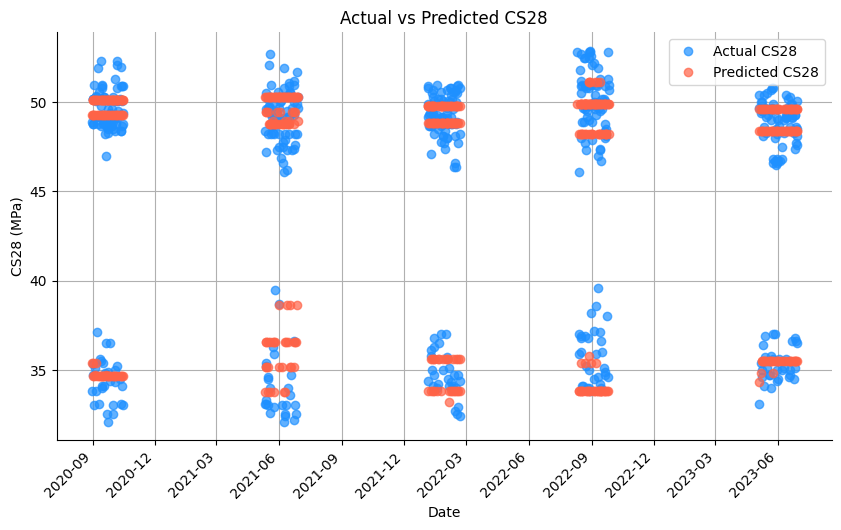

<IPython.core.display.Javascript object>

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improved x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Display every 3rd month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels for clarity

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_204_f_local_cm_p_btiss_top_scpm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [20]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [21]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Blaine,#200,#325,Initial setting time,Final setting time
Importances - 0,0.000000,0.002001,0.0,0.000000,0.000000,0.000569,0.000677,0.0,0.000000,0.000000,0.013756,0.982998,0.000000,0.000000
Importances - 1,0.005328,0.000000,0.0,0.011236,0.000669,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.982767,0.000000,0.000000
Importances - 2,0.003138,0.000000,0.0,0.014851,0.000000,0.000000,0.000547,0.0,0.000000,0.000000,0.000000,0.980399,0.000000,0.001065
Importances - 3,0.000000,0.000000,0.0,0.000000,0.000000,0.983435,0.000000,0.0,0.003634,0.002691,0.000000,0.009259,0.000489,0.000493
Importances - 4,0.000000,0.000000,0.0,0.014638,0.000000,0.001140,0.000000,0.0,0.000000,0.000234,0.000000,0.983988,0.000000,0.000000


<IPython.core.display.Javascript object>

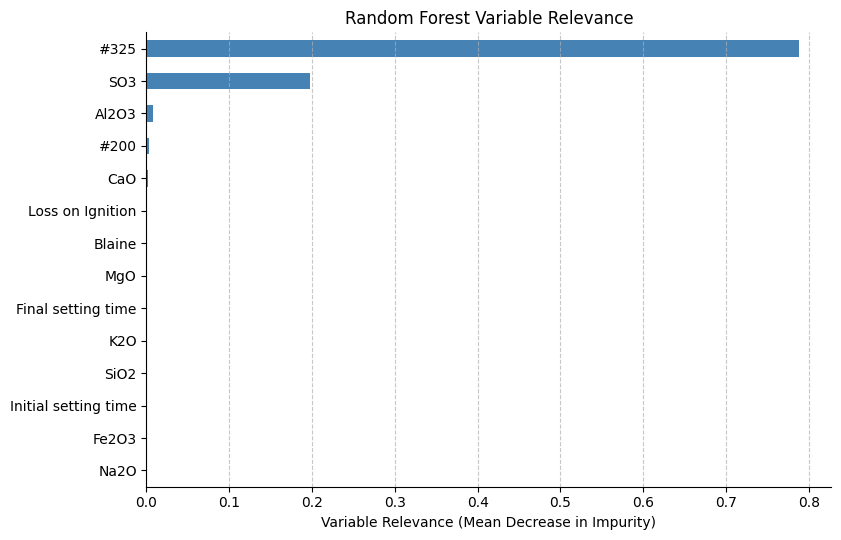

<IPython.core.display.Javascript object>

In [22]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Relevance")
plt.xlabel("Variable Relevance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

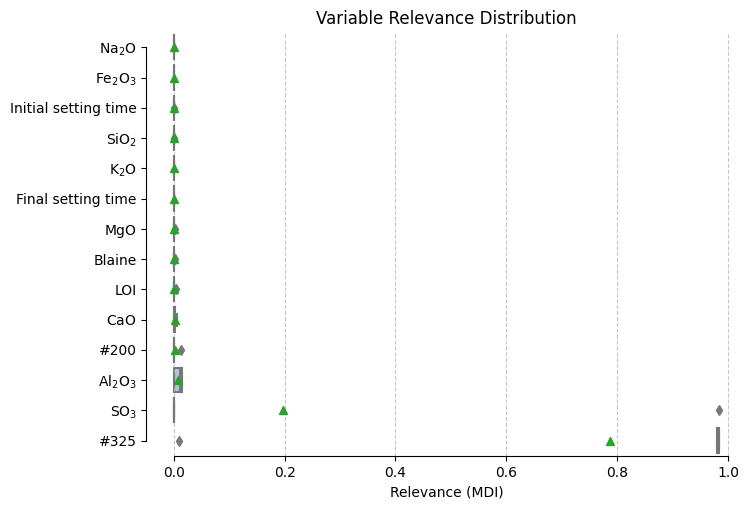

<IPython.core.display.Javascript object>

In [23]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)


# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# plt.rcParams.update(
#     {
#         "mathtext.fontset": "custom",
#         "mathtext.rm": "DejaVu Sans",
#         "mathtext.it": "DejaVu Sans:italic",
#         "mathtext.bf": "DejaVu Sans:bold",
#     }
# )


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_204_f_local_cm_p_btiss_top_scpm_dist_var_mdi_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [24]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [25]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]

    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        x.iloc[test_idx],
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

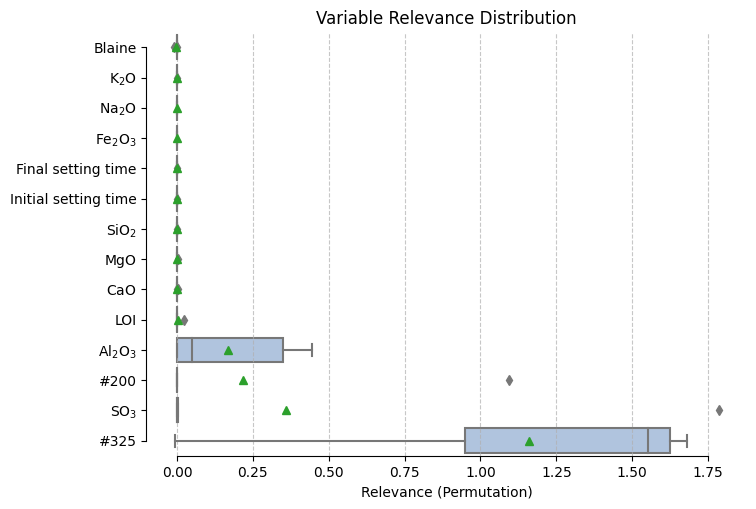

<IPython.core.display.Javascript object>

In [26]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_204_f_local_cm_p_btiss_top_scpm_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()